# Amazon Product Review Analysis


## Data

Dataset was extracted from kaggle at https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products

<h6 align="right"><a href = "https://xuelin-amy.github.io/playground/">Back to Home</a></h6>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline

pd.__version__

'1.0.1'

In [3]:
data = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', 
                    low_memory=False)
data.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


## Exploratory data anlysis

### statistic summary of reviews

In [4]:
data['dateAdded'] = pd.to_datetime(data.dateAdded)
data['reviews.len'] = data['reviews.text'].map(len)
data['hour'] = data.dateAdded.dt.strftime('%H')
data['ym'] = data.dateAdded.dt.strftime('%Y-%m')
data['dow'] = data.dateAdded.dt.strftime('%a')

In [5]:
data.groupby('ym')\
    .agg(num_product = pd.NamedAgg('name', pd.Series.nunique),
           num_review = pd.NamedAgg('reviews.text', pd.Series.nunique),
           avg_review_len = pd.NamedAgg('reviews.len', lambda i: np.round(np.mean(i),2)),
           avg_rating = pd.NamedAgg('reviews.rating', lambda i: np.round(np.mean(i),2))
          )\
    .reset_index()

,ym,num_product,num_review,avg_review_len,avg_rating
0,2015-12,2,43,155.34,4.84
1,2016-03,1,82,232.80,4.65
2,2016-04,1,371,140.05,4.46
3,2016-06,1,418,129.26,4.51
4,2016-08,1,96,156.11,4.67
5,2017-01,2,781,156.87,4.56
6,2017-03,12,1524,172.30,4.57
7,2017-11,1,4,89.25,5.00
8,2018-02,1,648,180.63,4.67
9,2018-04,1,195,184.67,4.65


In [6]:
res = data.groupby('primaryCategories')\
          .agg(num_product = pd.NamedAgg('name', pd.Series.nunique),
               num_review = pd.NamedAgg('reviews.text', pd.Series.nunique),
               avg_review_len = pd.NamedAgg('reviews.len', lambda i: np.round(np.mean(i),2)),
               avg_rating = pd.NamedAgg('reviews.rating', lambda i: np.round(np.mean(i),2))
              )\
          .reset_index()
res

,primaryCategories,num_product,num_review,avg_review_len,avg_rating
0,Electronics,18,2827,158.39,4.55
1,"Electronics,Hardware",2,1341,163.43,4.70
2,"Electronics,Media",1,24,521.21,4.67
3,"Office Supplies,Electronics",2,236,154.05,4.62


In [8]:
import altair as alt
alt.Chart(
    res.melt(id_vars='primaryCategories', var_name='variable', value_name='value')
).mark_bar().encode(
    y = 'primaryCategories:N',
    x = 'value:Q', 
    color = 'variable:N',
    column = 'variable:N',
    tooltip = ['primaryCategories','variable','value']
).resolve_scale(
    x='independent'
).properties(
    width = 200
)

alt.Chart(...)

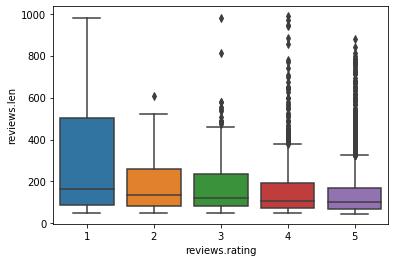

In [46]:
# correlation between length and rating
sns.boxplot('reviews.rating','reviews.len', data = data.query('`reviews.len` < 1000'))

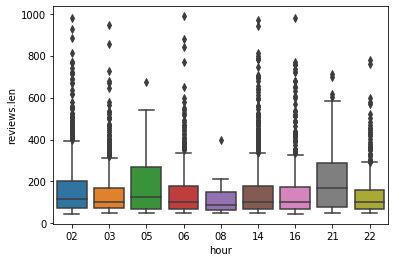

In [45]:
sns.boxplot('hour','reviews.len', data = data.query('`reviews.len` < 1000'))

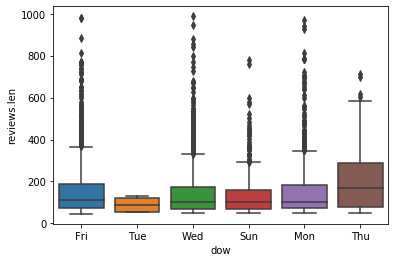

In [43]:
sns.boxplot('dow','reviews.len', data = data.query('`reviews.len` < 1000'))

In [12]:
# check some random reviews
random_reviews = data.sample(5)

for i in range(len(random_reviews)):
    print('Review #{} ({} stars) by {}'.format(i, 
                                               random_reviews['reviews.rating'].iloc[i],
                                               random_reviews['reviews.username'].iloc[i]))
    print(random_reviews['reviews.title'].iloc[i])
    print(random_reviews['reviews.text'].iloc[i])
    print('\n')

Review #0 (5 stars) by TACO
I love everything you can do on it.
I like the portability of it. I take it with me when I babysit my granddaughter.


Review #1 (5 stars) by JohnP
Perfect size for my son
I had originally bought my son the Kindle Fire HDX. And it worked great for him. The only downfall to it was he wanted both the rear and front facing cameras. But it only came with the front facing camera. As children do they break things. And he broke the screen on this one after having it for a year. I did not want to spend that much money on the second kindle so that's why I chose this Amazon Fire 7-inch tablet. And it has the front and rear facing cameras and that my son wanted. All the features are the same. It is a great buy. I would highly recommend it.


Review #2 (5 stars) by Petie
Love protective case!
This item is perfect for children and great for parents. It provides a sense of security that it will not be damaged the first week a child uses it.


Review #3 (5 stars) by drd1
G

### World cloud by category

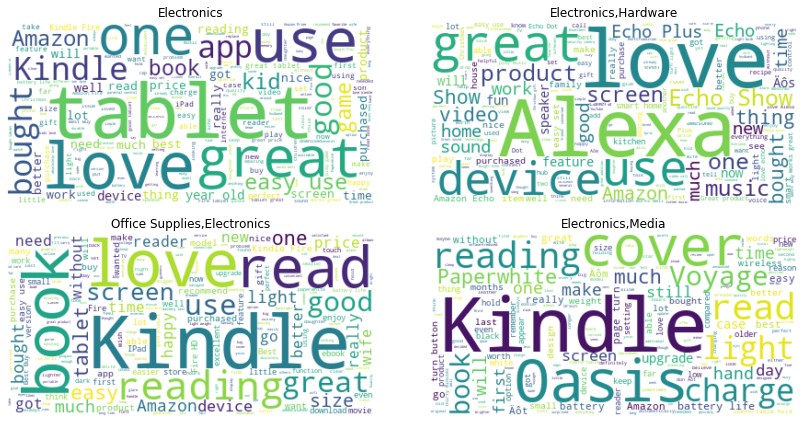

In [14]:
from wordcloud import WordCloud
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,6)
for i, cate in enumerate(data.primaryCategories.unique()):
    text = '\n'.join(data.loc[data.primaryCategories == cate, 'reviews.text'].values)
    wordcloud = WordCloud(background_color='white').generate(text)
    axs[i // 2, i % 2].imshow(wordcloud, interpolation="bilinear")
    axs[i // 2, i % 2].set_title(cate)
    axs[i // 2, i % 2].axis('off')
fig.tight_layout()
plt.show()

## Sentiment Analysis

In [15]:
analyzer = SentimentIntensityAnalyzer()
text = random_reviews['reviews.text'].iloc[0]
print(text)
analyzer.polarity_scores(text)

I like the portability of it. I take it with me when I babysit my granddaughter.


{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}

In [18]:
pos_reviews = data.loc[data['reviews.rating'] == 5, :].sample(2)
neg_reviews = data.loc[data['reviews.rating'] == 1, :].sample(2)
random_reviews = pd.concat([pos_reviews, neg_reviews])
scores = random_reviews['reviews.text'].map(lambda i: analyzer.polarity_scores(i)['compound'])
random_reviews['score'] = scores

In [20]:
for i in range(len(random_reviews)):
    print('Review #{} ({} stars) by {}'.format(i, 
                                               random_reviews['reviews.rating'].iloc[i],
                                               random_reviews['reviews.username'].iloc[i]))
    print(random_reviews['reviews.title'].iloc[i])
    print('{} (sentiment score: {:0.2f})'.format(random_reviews['reviews.text'].iloc[i],
                                               random_reviews['score'].iloc[i]))
    print('\n')

Review #0 (5 stars) by Xtreme56
Perfect
Having 3 amazon echos I had to pick up these to add to more rooms. These work best in the bedroom or kitchen. Video display is bright. Video calling is a great addition and is flawlessly, get them when they go on sale (sentiment score: 0.93)


Review #1 (5 stars) by mybestbuy
Excellent gift choice
This item was purchased as a gift for an annual holiday party. The recipient loved it. (sentiment score: 0.90)


Review #2 (1 stars) by EileenM
Charging Port Does Not Last - Not good for kids!
I bought a Kindle Fire 16GB for my 6 year old son in June. After 4 months the charging port came loose and the device will not charge. Best Buy is aware of the issue and will do nothing about it. Amazon will not warranty their product for more than 90 days and they said the charging ports often break if children are using them! They have no options to fix the device and only offer a small discount if I buy a new one. Amazon does not stand behind this product. They

In [21]:
scores = data['reviews.text'].map(lambda i: analyzer.polarity_scores(i)['compound'])
data['score'] = scores

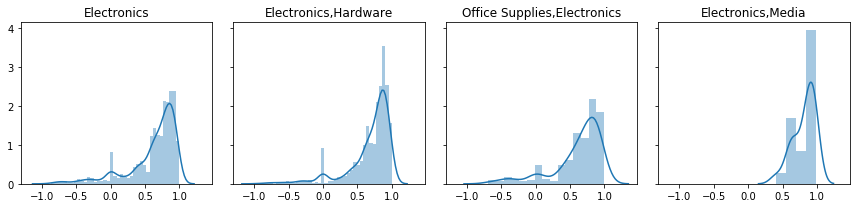

In [34]:
# sentiment score distribution

fig, axs = plt.subplots(ncols=4, sharey=True, sharex=True)
fig.set_size_inches(12, 3)
for idx, cate in enumerate(data.primaryCategories.unique()):
    sns.distplot(data.loc[data.primaryCategories == cate, 'score'].values, ax = axs[idx])
    axs[idx].set_title(cate)
fig.tight_layout()
plt.show()

In [53]:
# relationship between score and rating

data.groupby(['primaryCategories'])\
    .agg(num_review = pd.NamedAgg('reviews.text','count'),
         avg_score = pd.NamedAgg('score', lambda i: np.round(np.mean(i),2)),
         avg_rating = pd.NamedAgg('reviews.rating',lambda i: np.round(np.mean(i),2)))\
    .reset_index()

,primaryCategories,num_review,avg_score,avg_rating
0,Electronics,3276,0.62,4.55
1,"Electronics,Hardware",1435,0.69,4.70
2,"Electronics,Media",24,0.81,4.67
3,"Office Supplies,Electronics",265,0.61,4.62


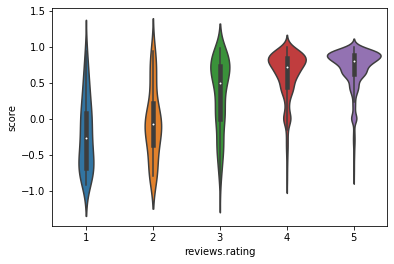

In [47]:
sns.violinplot(x='reviews.rating', y='score', data=data)

## Topic Modelling

In [98]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

def process_text(x):
    x = x.lower()
    return tokenizer.tokenize(x)

docs = data['reviews.text'].map(process_text)

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Remove stopwords
from nltk.corpus import stopwords
docs = [[token for token in doc if token not in stopwords.words('english')] for doc in docs]

In [105]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 670
Number of documents: 5000


In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 200
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

In [107]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.153135 -0.067681       1        1  27.436539
3      0.114747 -0.034638       2        1  23.437258
1     -0.022022 -0.085286       3        1  17.188089
0     -0.238989 -0.059237       4        1  16.672853
2     -0.006872  0.246843       5        1  15.265265, topic_info=        Term         Freq        Total Category  logprob  loglift
16      easy   764.000000   764.000000  Default  30.0000  30.0000
263   tablet  1559.000000  1559.000000  Default  29.0000  29.0000
346     echo   670.000000   670.000000  Default  28.0000  28.0000
107   bought   794.000000   794.000000  Default  27.0000  27.0000
5     kindle   798.000000   798.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
43      love   183.573822  1522.325073   Topic5  -3.9915  -0.2358
83    amazon   129.669052   729.633667   Topic5  -4.3391   0.1520
242  quality    78.157776   209.149933   Topic5  -4.8454   0.8953
113      new    76.010498   278.657135   Topic5  -4.8732   0.5805
47       one    77.527596   844.618896   Topic5  -4.8535  -0.5087

[321 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
343       1  0.043222       absolutely
343       4  0.950875       absolutely
478       4  0.980552  absolutely_love
325       1  0.114291          account
325       3  0.865344          account
...     ...       ...              ...
65        4  0.989468             year
66        4  0.996881         year_old
611       4  0.991089               yr
612       4  0.976251           yr_old
222       1  0.989189              äôs

[526 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])